In [79]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cftime

In [84]:
#reading in psl_anomaly data (psl - climatology) data in Pa
#psl_djf_anomaly = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly.nc')
psl_ann_anomaly = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_annual_anomaly.nc')

#need to slice for the NA region for the ensemble members
psl_ann_anomaly = psl_ann_anomaly.sel(time=slice(cftime.Datetime360Day(1851, 1, 1), cftime.Datetime360Day(2014, 12, 30)))
psl_ann_anomaly = psl_ann_anomaly.sel(lat=slice(20,80), lon=slice(-90,40))
print(psl_ann_anomaly)

#The NAO pattern from the ensemble mean, also in Pa/Pa?
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc')
ds = ds['nao_pattern_ann_em']

#finding the longitudes that are greater than 180, to stitch the NA region together from EM files (CVDP)
new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)

#creating a copy of the data array where the longitudes have been shifted
ds_shifted = ds.copy()
ds_shifted.coords['lon'] = new_lon

#Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
sorted_lon = np.sort(ds_shifted.lon)
ds_shifted = ds_shifted.sel(lon=sorted_lon)

print(ds_shifted)

historical_NAO_pattern = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))
#print(historical_NAO_pattern)


<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 25, lon: 53, time: 164)
Coordinates:
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0
  * time     (time) object 1kB 1851-12-30 00:00:00 ... 2014-12-30 00:00:00
Data variables:
    psl      (time, lat, lon) float64 2MB ...
<xarray.DataArray 'nao_pattern_ann_em' (lat: 71, lon: 144)> Size: 41kB
[10224 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    nens:       50
    long_name:  NAO spatial pattern (ANN) Ensemble Mean
    pcvar:      39.5%*
    units:      hPa


In [85]:
# ERA5 november sst anomalies projected onto era5 regression pattern
# Weight SST data by coslat to account for grid cell area decreasing with latitude
weights = np.cos(np.radians(psl_ann_anomaly["lat"].values))
weights_2d_era = weights[:, np.newaxis]

# weight sst anomalies by area of each gridcell
weighted_psl = psl_ann_anomaly["psl"] * weights_2d_era
weighted_regression = np.nan_to_num(historical_NAO_pattern * weights_2d_era)

 
# Combine lat and lon dimensions
weighted_sst_flat = weighted_psl.stack(spatial=["lat", "lon"])

 
# flatten weighted regression pattern
regression_flat = weighted_regression.flatten()

 
# dot product (weighted projection) between the weighted SST anomalies and regression pattern
weighted_projection = (weighted_sst_flat * regression_flat).sum(dim="spatial")


# normalise for unit variance
total_variance = np.sum(regression_flat**2)

NAO_ann_index = weighted_projection / total_variance

NAO_ann_index_norm = NAO_ann_index / np.sqrt(np.sum(np.abs(NAO_ann_index)))
#print(NAO_ann_index[0:12].values)
#NAO_ann_index.to_netcdf('NAO_ann_index.nc')
NAO_ann_index

<xarray.DataArray 'psl' (time: 164)> Size: 1kB
array([  38.66572089,  -30.82420815,   56.92674355, -198.50604806,
         27.36888513,  -37.24386323,  185.31693519,   96.03602277,
        -96.29080573,  -77.20332718,  -75.93384522,  -77.48065302,
        -54.81149574,   -4.22602848,  -18.8153674 ,  103.170838  ,
         -6.03888628,  213.03883172,   16.42743767,    6.13204643,
       -171.17064275,  107.38323304,   86.6745067 ,  -13.34400149,
       -148.43200401,   75.24997149, -104.47206225,    0.40031489,
       -217.75944304,  -19.05669613,   94.62034355, -231.50907071,
       -110.35477302,   22.00363632,   33.51065878,  -75.54913373,
         49.16307196,   65.51312231, -126.66497484,   34.08825008,
       -164.10260316,  -24.0844343 ,  -68.61929271, -189.2587237 ,
         94.56668012,   -3.40927323,  -21.23122314, -176.02609584,
       -193.08038214,   21.06445047, -106.31044202,   22.44638898,
        -78.75664058,  -16.81825934,   97.12081352,    2.12275344,
        -89.43228581,   93.31002227,   -5.32997194,   88.23911061,
       -169.79518909,   -8.1789802 ,   63.79899673,   28.92904631,
          9.35938892,  -26.27754644,  129.03920151,  -81.73319134,
       -107.00826982,    4.89541428,   42.19949335,  -53.99064718,
          2.30682747,   32.05446726,   30.82869373,   -7.89094992,
         82.26690884,   15.34272867,  -60.52397542,  -42.38655373,
...
         70.96786588,   95.13930786, -211.70561953,  -87.58424061,
        -42.95200424, -156.67377062,  102.91306257,   15.19873396,
         74.16249727, -100.76966322,   31.16385415,   15.97471912,
         47.59143149,   71.96073026, -114.44542225,  -30.95724252,
        -78.65771088,  -30.40115154,   35.90085164,  -22.79073337,
        -28.44211744,   79.3687157 ,  -77.916548  ,  125.25079104,
        -84.21871505, -105.89859607,   16.47209793,   32.55783966,
        162.68498791,    8.7144612 ,   51.24494341,   21.13895493,
        -75.3550842 , -187.53882592,  -57.37910688, -258.90923201,
        155.3394678 ,   12.38599679,   74.17133702,   36.27110808,
        -30.55154548,  -90.76211149,  167.75847777,  159.34094638,
        158.80117888,   44.42708742,    6.94075524,   46.98388337,
         58.75221969,   13.84326599,   15.91253086,   99.28001382,
        112.19963098,   32.19572115,   55.37250687,   -2.71202666,
        -78.53302155,   12.8172966 ,   16.8207103 ,   73.35046707,
         88.65399655,   63.46545937,   46.9781398 ,   23.93626046,
        171.2232399 ,  -30.63442273,  228.67751872,    9.58848292,
         67.98847922,   55.87612074,  116.16295292,   62.35106085,
        -63.87246225,   -3.30527436, -123.11666924, -103.64160054,
        -59.56535743,  185.96477065,  115.86517682,  -48.49128779])
Coordinates:
  * time     (time) object 1kB 1851-12-30 00:00:00 ... 2014-12-30 00:00:00

In [86]:
ds_CVDP = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r11i1p1f3.cvdp_data.1850-2014.nc')
ds_CVDP_ann = ds_CVDP['nao_timeseries_ann'].isel(TIME=slice(1, None))
#ds_CVDP_djf.plot()
#print(len(ds_CVDP_djf))

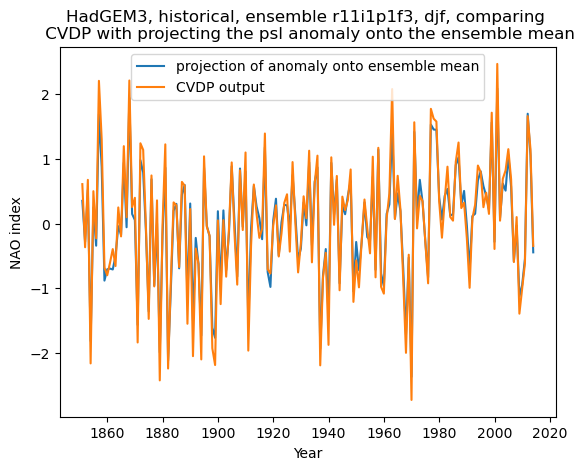

In [87]:
time_NAO_ann = np.arange(1851,2015)
fig, ax = plt.subplots()

ax.plot(time_NAO_ann, NAO_ann_index_norm, label="projection of anomaly onto ensemble mean")
ax.plot(time_NAO_ann, ds_CVDP_djf, label='CVDP output')
ax.set_title('HadGEM3, historical, ensemble r11i1p1f3, djf, comparing \n CVDP with projecting the psl anomaly onto the ensemble mean')
ax.set_ylabel('NAO index')
ax.set_xlabel('Year')
ax.legend()
#plt.savefig('historical_anomaly_projection_NAO_index_season_calc_after')
